In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import scipy.spatial
from pathlib import Path
from typing import Tuple, Callable, Optional, List, Union
from tqdm import trange
from dm_control.rl.control import PhysicsError
from PIL import Image


from flygym.arena.mujoco_arena import (
    FlatTerrain,
    GappedTerrain,
    BlocksTerrain,
    MixedTerrain,
)
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs
import flygym.util.vision as vision
from flygym.arena import BaseArena
from flygym.arena.mujoco_arena import OdorArena, FlatTerrain, GappedTerrain, BlocksTerrain
from flygym.util.data import color_cycle_rgb
from flygym.util.config import num_ommatidia_per_eye

from arena import ObstacleOdorArena

pygame 2.5.1 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = Path(pkg_resources.resource_filename("flygym", "data"))
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [4]:
def sample_visual_data(
    nmf, obstacle_positions, action, visualize=False, camera="birdeye_cam"
):
    # Change obstacle positions in the arena
    for i in range(obstacle_positions.shape[0]):
        pos_xyz = np.array([*obstacle_positions[i, :], nmf.arena.obstacle_z_pos])
        nmf.physics.bind(nmf.arena.obstacle_bodies[i]).mocap_pos = pos_xyz
        nmf.step(action)

    # Render visual input
    nmf._last_vision_update_time = -np.inf  # hack: this forces visual input update
    nmf._update_vision()
    visual_input = nmf.curr_visual_input.copy()
    raw_cam_imgs = nmf.curr_raw_visual_input.copy()

    # Calculate obstacle positions relative to the fly
    fly_rotation = nmf.spawn_orient[2]
    rot_matrix = np.array(
        [
            [np.cos(fly_rotation), -np.sin(fly_rotation)],
            [np.sin(fly_rotation), np.cos(fly_rotation)],
        ]
    )
    obstacle_positions_transformed = obstacle_positions - nmf.spawn_pos[:2]
    obstacle_positions_transformed[:, 1] *= -1  # change y to right-hand-positive
    obstacle_positions_transformed = (rot_matrix @ obstacle_positions_transformed.T).T

    # Visualize
    if visualize:
        fig, axs = plt.subplots(1, 5, figsize=(10, 5), tight_layout=True)
        birdeye_img = nmf.physics.render(camera_id=camera, height=512, width=512)
        axs[0].imshow(birdeye_img)
        axs[0].axis("off")
        for i in range(2):
            axs[i + 1].imshow(raw_cam_imgs[i], cmap="gray", vmin=0, vmax=255)
            axs[i + 1].axis("off")
        for i in range(2):
            vis = vision.hex_pxls_to_human_readable(
                visual_input[i], vision.ommatidia_id_map
            )
            axs[i + 3].imshow(vis, cmap="gray", vmin=0, vmax=255)
            axs[i + 3].axis("off")

    return visual_input, obstacle_positions_transformed

/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


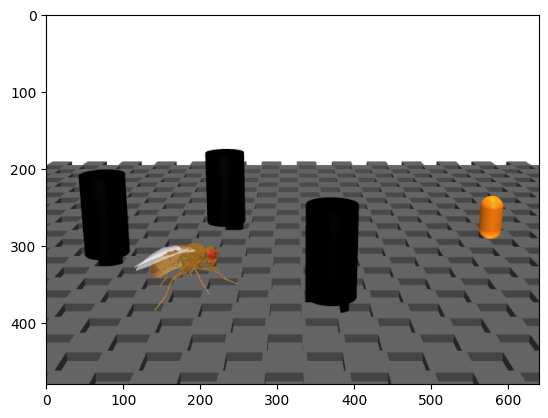

In [5]:
terrain_arena = BlocksTerrain(
    x_range=(-20, 40), y_range=(-20, 20), height_range=(0.3, 0.3), ground_alpha=1
)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5), (-10, -10)]),
    marker_size=0.5,
    obstacle_colors=(0, 0, 0, 1),
    user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
)
sim_params = MuJoCoParameters(
    render_playspeed=0.2,
    render_camera="user_cam",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
    render_playspeed_text=False,
)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(12, -4, 0.5),
    spawn_orient=(0, 0, np.pi / 2 + np.deg2rad(20)),
)
action = {"joints": data_block[:, 0]}
for i in range(100):
    nmf.step(action)
    nmf.render()

plt.imshow(nmf._frames[-1])
imageio.imsave("outputs/env_overview.png", nmf._frames[-1])

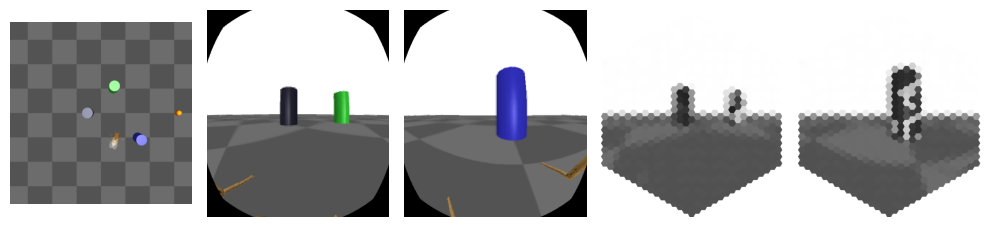

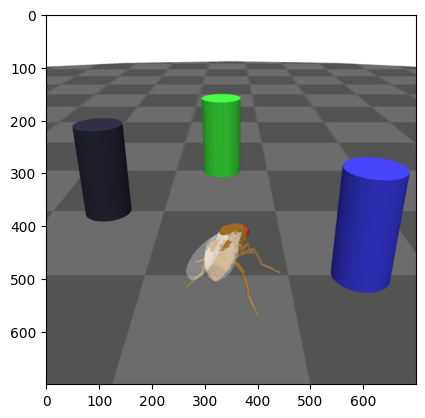

In [8]:
terrain_arena = FlatTerrain()
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)
sim_params = MuJoCoParameters(
    render_playspeed=0.2,
    render_camera="user_cam",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(13, -5, 0.5),
    spawn_orient=(0, 0, np.pi / 2 + np.deg2rad(70)),
)
action = {"joints": data_block[:, 0]}
for i in range(100):
    nmf.step(action)
    nmf.render()

sample_visual_data(
    nmf, np.array([(7.5, 0), (12.5, 5), (17.5, -5)]), action, visualize=True
)
plt.savefig("outputs/vision_sim.pdf", transparent=True)
plt.show()

env_viz = nmf.physics.render(camera_id="user_cam", height=700, width=700)

plt.imshow(env_viz)
imageio.imsave("outputs/behind_fly_view.png", env_viz)